# The leads in bridge.
The problem we are trying to treat is difficult mostly because different pairs use different bidding systems so we can not apply the methods of Machine Learning to the bidding sequences. At first we should somehow decode the information from the sequence.

## Learning to chose the suit to lead on (pass) - 1nt - all pass.
In this section we are "cheating" using the fact that in (almost) all bidding systems 1nt opening promises (semi-)regular hand, thus the priniples of the lead are the same.

*to add: treat the same hands with differents leads; check the dependence of 1nt force (!need to calculate points of declarer)*

### Preprocessing the data.

Script to get the leading hand and the lead from file "temp_final.DAT" which contains hands + leads

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from os import sys
import path_jupy
sys.path.append(path_jupy.give_path())
from Pickle_Data.extract_data import load_file, BridgeDeal

%matplotlib inline

In [2]:
filename = "Search.bin"
data = load_file(filename)

Creating two arrays: __hands__ and corresponding leads. Enumerating leads by __suits_lead__.

In [18]:
leads = [data[i].lead.upper() for i in range(len(data))]
hands = [data[i].hands[0] for i in range(len(data))]

length = len(data)
print(length)
#S = 0, H = 1, D = 2, C = 3
suits_lead = []
for i in range(length):
    if leads[i][0] == 'S':
        suits_lead.append(0)
    if leads[i][0] == 'H':
        suits_lead.append(1)
    if leads[i][0] == 'D':
        suits_lead.append(2)
    if leads[i][0] == 'C':
        suits_lead.append(3)
print(len(suits_lead))

24807
819


### Vizualisation of the data.

Text(0.5,0,'Suits')

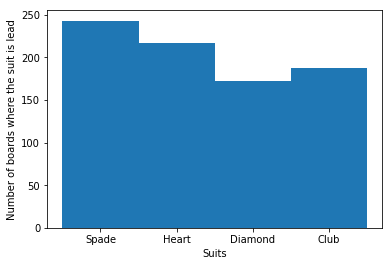

In [17]:
plt.hist(suits_lead, bins = [0, 1, 2, 3, 4])
plt.xticks([0.5, 1.5, 2.5, 3.5], ['Spade', 'Heart', 'Diamond', 'Club'])
plt.ylabel('Number of boards where the suit is lead')
plt.xlabel('Suits')

### Learning.

#### Implementing the basic rule "lead the best suit", where "the best" means the longest (and major>minor)

In [7]:
number_of_cardes = np.zeros((length, 4), int)
for i in range(length):
    number_of_cardes[i][0] = sum(hands[i][0:13])
    number_of_cardes[i][1] = sum(hands[i][13:26])
    number_of_cardes[i][2] = sum(hands[i][26:39])
    number_of_cardes[i][3] = sum(hands[i][39:52])

best_suit = []
for i in range(length):
    best_suit.append(np.argmax(number_of_cardes[i]))
print(len(best_suit))

Calculate the percantage of applying the empiric rule in the given data

In [12]:
a = np.array(best_suit)
print(len(a))
b = np.array(suits_lead)
print(len(b))
print(1.0*np.count_nonzero(a==b)/length)

24807
819


NameError: name 'ab' is not defined

So we can see that the __empiric rule__ which is taught to the beginners works in 3 bords out of 4.

#### One vs rest classification.

In [9]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

Learning and checking the OneVsRestClassifier classifier on cross validation.

In [11]:
classifier = OneVsRestClassifier(SVC(random_state=0))
classifier_scoring = cross_val_score(classifier, hands, suits_lead, scoring = 'accuracy', cv = 5)
print('OneVsRest Classifier')
print('Accuracy scores: ', classifier_scoring)
print('mean: {}, max: {}, min: {}, std: {}'.format(classifier_scoring.mean(), classifier_scoring.max(), 
                                                     classifier_scoring.min(), classifier_scoring.std()))

ValueError: Found input variables with inconsistent numbers of samples: [24807, 819]

Learning and checking a SVM classifier on train_test_split

In [57]:
classifier = SVC()
classifier_scoring = cross_val_score(classifier, hands, suits_lead, scoring='accuracy', cv=5)
print('SVC')
print('Accuracy scores: ', classifier_scoring)
print('mean: {}, max: {}, min: {}, std: {}'.format(classifier_scoring.mean(), classifier_scoring.max(),
                                                   classifier_scoring.min(), classifier_scoring.std()))


SVC
Accuracy scores:  [ 0.69230769  0.68480726  0.69476082  0.68949772  0.70547945]
mean: 0.693370587508, max: 0.705479452055, min: 0.684807256236, std: 0.00689951973097


#### Increasing number of boards by swipping majors and minors.

In [58]:
#exchange majors; exchange minors; exchange both
# !!on peut utiliser np.hstack((a, b))
for i in range(length):
    
    #exchange majors
    new_hand = np.zeros(52)
    new_hand[:13], new_hand[13:26], new_hand[26:52] = hands[i][13:26], hands[i][0:13], hands[i][26:52]
    hands.append(new_hand)
    if suits_lead[i] == 0:
        suits_lead.append(1)
    if suits_lead[i] == 1:
        suits_lead.append(0)
    if suits_lead[i] == 2:
        suits_lead.append(2)
    if suits_lead[i] == 3:
        suits_lead.append(3)
        
    #exchange minors
    new_hand = np.zeros(52)
    new_hand[:26], new_hand[26:39], new_hand[39:52] = hands[i][0:26], hands[i][39:52], hands[i][26:39]
    hands.append(new_hand)
    if suits_lead[i] == 0:
        suits_lead.append(0)
    if suits_lead[i] == 1:
        suits_lead.append(1)
    if suits_lead[i] == 2:
        suits_lead.append(3)
    if suits_lead[i] == 3:
        suits_lead.append(2)
        
    #exchange both
    new_hand = np.zeros(52)
    new_hand[:13], new_hand[13:26], new_hand[26:39], new_hand[39:52] = hands[i][13:26], hands[i][0:13], hands[i][39:52], hands[i][26:39]
    hands.append(new_hand)
    if suits_lead[i] == 0:
        suits_lead.append(1)
    if suits_lead[i] == 1:
        suits_lead.append(0)
    if suits_lead[i] == 2:
        suits_lead.append(3)
    if suits_lead[i] == 3:
        suits_lead.append(2)

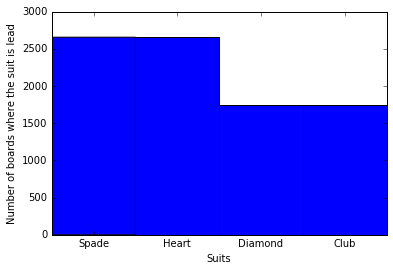

In [60]:
plt.hist(suits_lead, bins = [0, 1, 2, 3, 4])
plt.xticks([0.5, 1.5, 2.5, 3.5], ['Spade', 'Heart', 'Diamond', 'Club'])
plt.ylabel('Number of boards where the suit is lead')
plt.xlabel('Suits')

Learning and checking bigger dataset on the OneVsRestClassifier classifier on cross_vall

In [59]:
classifier = OneVsRestClassifier(SVC(random_state=0))
classifier_scoring = cross_val_score(classifier, hands, suits_lead, scoring = 'accuracy', cv = 5)
print('OneVsRest Classifier')
print('Accuracy scores: ', classifier_scoring)
print('mean: {}, max: {}, min: {}, std: {}'.format(classifier_scoring.mean(), classifier_scoring.max(), 
                                                     classifier_scoring.min(), classifier_scoring.std()))

OneVsRest Classifier
Accuracy scores:  [ 0.76193182  0.75142207  0.77189989  0.73947668  0.74971559]
mean: 0.754889207777, max: 0.771899886234, min: 0.739476678043, std: 0.0110931962909


Decision trees

In [61]:
from sklearn import tree

In [63]:
classifier = tree.DecisionTreeClassifier()
classifier_scoring = cross_val_score(classifier, hands, suits_lead, scoring = 'accuracy', cv = 5)
print('OneVsRest Classifier')
print('Accuracy scores: ', classifier_scoring)
print('mean: {}, max: {}, min: {}, std: {}'.format(classifier_scoring.mean(), classifier_scoring.max(), 
                                                     classifier_scoring.min(), classifier_scoring.std()))

OneVsRest Classifier
Accuracy scores:  [ 0.50340909  0.38850967  0.41240046  0.40614334  0.41240046]
mean: 0.424572603165, max: 0.503409090909, min: 0.38850967008, std: 0.0403774364927


As we can see decision trees don't work well

### Human check

Taking OneVsRestClassifier and fittig all data

In [65]:
classifier = OneVsRestClassifier(SVC(random_state=0))
classifier.fit(hands, suits_lead)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

Giving the hands:
5432 432 423 432 ;
432 5432 432 432 ;
432 432 5432 432 ;
432 432 432 5432 ;
5432 432 32 5432 ;
AKQJ 32 32 65432 ;
A5432 32 32 KQJT ;
KQJT 32 32 A5432 ;

In [82]:
checking = []
specific_hand = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
checking.append(specific_hand)

specific_hand = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
checking.append(specific_hand)

specific_hand = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
checking.append(specific_hand)

specific_hand = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
checking.append(specific_hand)

specific_hand = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
checking.append(specific_hand)

specific_hand = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 
           1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
checking.append(specific_hand)

specific_hand = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 
           1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]
checking.append(specific_hand)

specific_hand = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 
           1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
           1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]
checking.append(specific_hand)

In [83]:
classifier.predict(checking)

array([0, 1, 2, 3, 0, 3, 3, 0])

Seems very reasonable.